<font size="5">**DeepRacer Local Training Logs Analysis**</font>

<font size="3">This is my logs analysis tool that I created so you can visualize the performance of your model in local training. Just click the **double arrow button >>** at the top to run.</font>

By: Nathan Liang



<font size="4">Imports:</font>

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import MinMaxScaler

<font size="4">Get the S3 model prefix name</font>

In [2]:
run_env = 'run.env'
with open(run_env, 'r') as f:
    for line in f.readlines():
        if "DR_LOCAL_S3_MODEL_PREFIX=" in line:
            spl_pnt = '='
            MODEL_PREFIX = line.partition(spl_pnt)[2]
            MODEL_PREFIX = MODEL_PREFIX.replace('\n','')
            
MODEL_PREFIX

'rl-deepracer-1'

Specify the name of the metrics files<font size="4">your_text_here</font>

In [3]:
metrics1_fname = 'data/minio/bucket/%s/metrics/TrainingMetrics.json' %MODEL_PREFIX
metrics2_fname = 'data/minio/bucket/%s/metrics/TrainingMetrics_1.json' %MODEL_PREFIX

<font size="4">Compile the metrics logs so that they can be read by this notebook</font>

In [4]:
def json_to_list(file):
    file = file.replace("{","[")
    file = file.replace("}","]")
    file = file.replace('"', '')
    file = file.replace('[metrics: ',"")
    file = file.replace(', version: 2.0, best_model_metric: progress]',"")
    file = file.replace('reward_score: ', '"')
    file = file.replace(', metric_time: ', '","')
    file = file.replace(', start_time: ', '","')
    file = file.replace(', elapsed_time_in_milliseconds: ', '","')
    file = file.replace(', episode: ', '","')
    file = file.replace(', trial: ', '","')
    file = file.replace(', phase: ', '","')
    file = file.replace(', completion_percentage: ', '","')
    file = file.replace(', episode_status: ', '","')
    file = file.replace(']', '"]')
    file = file.replace('"]"]', '"]]')
    #print(file)
    return json.loads(file)

In [5]:
with open(metrics1_fname, 'r') as file1:
    for line in file1:
        metrics1 = json_to_list(line)
with open(metrics2_fname, 'r') as file2:
    for line in file2:
        metrics2 = json_to_list(line)

<font size="4">Find the number of episodes per iteration for each robomaker container</font>

In [6]:
def find_episodes(data_list):
  for d in range(len(data_list)):
    if data_list[d][6] == 'evaluation':
      trial = int(data_list[d][5])
      return trial

episodes_per_iteration = find_episodes(metrics1)
episodes_per_iteration

20

Parse the data<font size="4">your_text_here</font>

In [7]:
def parse_data(data_list):
    training = []
    evaluation = []
    x = 1
    y = 1
    for d in range(len(data_list)):
        if data_list[d][6] == 'training':
            iteration = x
            episode = int(data_list[d][4])
            reward = float(data_list[d][0])
            progress = float(data_list[d][7])
            elapsed_time = float(data_list[d][3])
            trial = int(data_list[d][5])
            trial = trial % episodes_per_iteration
            status = data_list[d][8]
            if trial == 0:
                trial = episodes_per_iteration
                x += 1
            training.append([iteration, episode, reward, progress, elapsed_time, trial, status])
        elif data_list[d][6] == 'evaluation':
            iteration = x - 1
            episode = int(data_list[d][4])
            reward = float(data_list[d][0])
            progress = float(data_list[d][7])
            elapsed_time = float(data_list[d][3])
            trial = y
            status = data_list[d][8]
            y += 1
            try:
                if data_list[d+1][6] == 'training':
                    y = 1
            except:
                pass
            evaluation.append([iteration, episode, reward, progress, elapsed_time, trial, status])
            
    return [training, evaluation]

In [8]:
training_data1, evaluation_data1 = parse_data(metrics1)
training_data2, evaluation_data2 = parse_data(metrics2)

<font size="4">Convert to Dataframe</font>

In [9]:
header = ['iteration', 'episode', 'reward', 'progress', 'elapsed_time', 'trial', 'status']
sim_df1 = pd.DataFrame(training_data1, columns=header)
sim_df2 = pd.DataFrame(training_data2, columns=header)
sim_df_E = pd.DataFrame(evaluation_data1, columns=header)
sim_df2

,iteration,episode,reward,progress,elapsed_time,trial,status
0,1,1,96.0,3.0,1514.0,1,Off track
1,1,2,167.0,4.0,1874.0,2,Off track
2,1,3,252.0,6.0,2570.0,3,Off track
3,1,4,40.0,1.0,1268.0,4,Off track
4,1,5,40.0,1.0,1062.0,5,Off track
...,...,...,...,...,...,...,...
2789,140,2790,513.0,12.0,3973.0,10,Off track
2790,140,2791,690.0,17.0,6275.0,11,Crashed
2791,140,2792,613.0,15.0,4657.0,12,Crashed
2792,140,2793,58.0,2.0,1291.0,13,Off track


<font size="4">Convert Episode Data into Iteration Data</font>

In [10]:
def episode_to_iteration(dataframe):
    sim_df_iterations = dataframe[dataframe["trial"] == 1][["iteration"]].copy()
    sim_df_iterations["avg_progress"] = dataframe.groupby("iteration")["progress"].transform("mean")
    sim_df_iterations["avg_reward"] = dataframe.groupby("iteration")["reward"].transform("mean")
    
    episode_count = dataframe.groupby("iteration")["episode"].count()
    sim_df_iterations = pd.merge(sim_df_iterations,episode_count,on="iteration",how="outer")
    sim_df_iterations.rename(columns={"episode":"episodes"}, inplace=True)
    
    complete_laps = dataframe[dataframe["status"] == "Lap complete"].groupby("iteration")["status"].count()
    sim_df_iterations = pd.merge(sim_df_iterations, complete_laps,on="iteration",how="outer")
    sim_df_iterations.rename(columns={"status":"complete_laps"}, inplace=True)
    sim_df_iterations["complete_laps"].fillna(0, inplace=True)
    sim_df_iterations["complete_laps"] = sim_df_iterations["complete_laps"].astype(int)
    sim_df_iterations["pct_completed_laps"] = (sim_df_iterations["complete_laps"] / sim_df_iterations["episodes"] * 100.0)
    
    offtrack_count = dataframe[dataframe["status"] == "Off track"].groupby("iteration")["status"].count()
    sim_df_iterations = pd.merge(sim_df_iterations, offtrack_count,on="iteration",how="outer")
    sim_df_iterations.rename(columns={"status":"offtrack_count"}, inplace=True)
    sim_df_iterations["offtrack_count"].fillna(0, inplace=True)
    sim_df_iterations["offtrack_count"] = sim_df_iterations["offtrack_count"].astype(int)
    sim_df_iterations["pct_offtrack"] = (sim_df_iterations["offtrack_count"] / sim_df_iterations["episodes"] * 100.0)
    
    crash_count = dataframe[dataframe["status"] == "Crashed"].groupby("iteration")["status"].count()
    sim_df_iterations = pd.merge(sim_df_iterations, crash_count,on="iteration",how="outer")
    sim_df_iterations.rename(columns={"status":"crash_count"}, inplace=True)
    sim_df_iterations["crash_count"].fillna(0, inplace=True)
    sim_df_iterations["crash_count"] = sim_df_iterations["crash_count"].astype(int)
    sim_df_iterations["pct_crashed"] = (sim_df_iterations["crash_count"] / sim_df_iterations["episodes"] * 100.0)
    
    # Create a simple moving average for completed laps, offtrack count, and crash count to reduce deviation
    sim_df_iterations['pct_completed_laps_SMA'] = sim_df_iterations['pct_completed_laps'].rolling(window=3).mean()
    sim_df_iterations['pct_offtrack_SMA'] = sim_df_iterations['pct_offtrack'].rolling(window=3).mean()
    sim_df_iterations['pct_crashed_SMA'] = sim_df_iterations['pct_crashed'].rolling(window=3).mean()

    return sim_df_iterations

In [11]:
sim_df_iterations2 = episode_to_iteration(sim_df2)

sim_df_iterations1 = episode_to_iteration(sim_df1)
sim_df_iterations_E = episode_to_iteration(sim_df_E)

<font size="4">Functions for Creating Training Graphs</font>

In [12]:
def plot_training_graph(df_slice_iterations, df_slice_e):
    font_size=16
    if(len(df_slice_iterations)>0):
        fig = plt.figure(figsize=(24, 10))
        ax = plt.gca()  # gca stands for 'get current axis'
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # force integer labels on x-axis
        
        df_slice_iterations.plot(kind='line',linestyle='solid',x='iteration',y='avg_progress',label='Average Training Progress',linewidth=3,color='blue',fontsize=font_size,ax=ax)
        df_slice_e.plot(kind='line',linestyle='solid',x='iteration',y='avg_progress',label='Average Evaluation Progress',linewidth=3,color='red',fontsize=font_size,ax=ax)
        ax.legend().remove()
        ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
        ax.set_ylabel('Progress', fontsize=font_size)
        plt.yticks(np.arange(0, 105, step=10))
        
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        df_slice_iterations.plot(kind='line',linestyle='solid',x='iteration',y='avg_reward',label='Average Training Reward',linewidth=3,color='green',fontsize=font_size,ax=ax2)

        ax2.legend().remove()
        ax2.set_ylabel('Reward', fontsize=font_size)

        plt.plot([], [], ' ', label='Iterations: %d' % df_slice_iterations["iteration"].max())

        fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=14, title="Legend")
        plt.subplots_adjust(bottom=0.15)

        max_rewards_iter = df_slice_iterations['avg_reward'].idxmax()
        if (max_rewards_iter >= 0):
            xmax_rewards = df_slice_iterations['iteration'][max_rewards_iter]
            ymax_rewards = df_slice_iterations['avg_reward'].max()
            plt.axvline(x=xmax_rewards,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_rewards,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_rewards*0.995, ymax_rewards*1.005, 'Max Rewards @ %d' % xmax_rewards, ha='right', va='bottom', size=font_size)

        max_progress_iter = df_slice_iterations['avg_progress'].idxmax()
        if (max_progress_iter >= 0):
            xmax_progress = df_slice_iterations['iteration'][max_progress_iter]
            ymax_progress = df_slice_iterations['avg_progress'].max()
            plt.axvline(x=xmax_progress,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_progress,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_progress*0.995, ymax_progress*1.005, 'Max Train Progress @ %d' % xmax_progress, ha='right', va='bottom', size=font_size)
            
        max_eval_iter = df_slice_e['avg_progress'].idxmax()
        if (max_progress_iter >= 0):
            xmax_progress = df_slice_iterations['iteration'][max_progress_iter]
            ymax_progress = df_slice_iterations['avg_progress'].max()
            plt.axvline(x=xmax_progress,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_progress,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_progress*0.995, ymax_progress*1.005, 'Max Training Evaluation @ %d' % xmax_progress, ha='right', va='bottom', size=font_size)

        plt.show()
        
def plot_pct_competed_laps(df_slice_iterations1, df_slice_iterations2):
    font_size=16
    if(len(df_slice_iterations1)>0):
        fig = plt.figure(figsize=(24, 10))
        ax1 = fig.add_subplot(121)
        
        df_slice_iterations1.plot(kind='line',linestyle=(0,(1,1)),x='iteration',y='pct_completed_laps_SMA',label='Percent Completed Laps SMA',linewidth=3,color='dodgerblue',fontsize=font_size,ax=ax1)
        df_slice_iterations1.plot(kind='line',linestyle='solid',x='iteration',y='avg_progress',label='Average Training Progress',linewidth=3,color='blue',fontsize=font_size,ax=ax1)
        
        ax1.legend().remove()
        ax1.set_xlabel(ax1.get_xlabel(), fontsize=font_size)
        ax1.set_ylabel('Percentage (%)', fontsize=font_size)
        plt.yticks(np.arange(0, 105, step=10))
        
        ax2 = fig.add_subplot(122)
        df_slice_iterations2.plot(kind='line',linestyle=(0,(1,1)),x='iteration',y='pct_completed_laps_SMA',label='Percent Completed Laps SMA',linewidth=3,color='dodgerblue',fontsize=font_size,ax=ax2)
        df_slice_iterations2.plot(kind='line',linestyle='solid',x='iteration',y='avg_progress',label='Average Training Progress',linewidth=3,color='blue',fontsize=font_size,ax=ax2)
        ax2.legend().remove()
        ax2.set_xlabel(ax2.get_xlabel(), fontsize=font_size)
        ax2.set_ylabel('Percentage (%)', fontsize=font_size)
        
        plt.plot([], [], ' ', label='Iterations: %d' % df_slice_iterations1["iteration"].max())
        fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=14, title="Legend")
        plt.subplots_adjust(bottom=0.15)
        
        plt.yticks(np.arange(0, 105, step=10))
        plt.show()
    
def episode_end_status(df_slice_iterations1, df_slice_iterations2):
    font_size=16
    if(len(df_slice_iterations1)>0):
        fig = plt.figure(figsize=(24, 10))
        ax1 = fig.add_subplot(121)
        plt.yticks(np.arange(0, 105, step=10))
        
        df_slice_iterations1.plot(kind='line',linestyle=(0,(1,1)),x='iteration',y='pct_completed_laps_SMA',label='Percent Completed Laps SMA',linewidth=2,color='dodgerblue',fontsize=font_size,ax=ax1)
        df_slice_iterations1.plot(kind='line',linestyle='dashdot',x='iteration',y='pct_offtrack_SMA',label='Percent Offtrack SMA',linewidth=2,color='brown',fontsize=font_size,ax=ax1)
        df_slice_iterations1.plot(kind='line',linestyle='dashdot',x='iteration',y='pct_crashed_SMA',label='Percent Crashed SMA',linewidth=2,color='darkorange',fontsize=font_size,ax=ax1)
        
        ax2 = fig.add_subplot(122)
        
        df_slice_iterations2.plot(kind='line',linestyle=(0,(1,1)),x='iteration',y='pct_completed_laps_SMA',label='Percent Completed Laps SMA',linewidth=2,color='dodgerblue',fontsize=font_size,ax=ax2)
        df_slice_iterations2.plot(kind='line',linestyle='dashdot',x='iteration',y='pct_offtrack_SMA',label='Percent Offtrack SMA',linewidth=2,color='brown',fontsize=font_size,ax=ax2)
        df_slice_iterations2.plot(kind='line',linestyle='dashdot',x='iteration',y='pct_crashed_SMA',label='Percent Crashed SMA',linewidth=2,color='darkorange',fontsize=font_size,ax=ax2)
        
        ax1.legend().remove()
        ax1.set_xlabel(ax1.get_xlabel(), fontsize=font_size)
        ax1.set_ylabel('Percentage (%)', fontsize=font_size)
        

        ax2.legend().remove()
        ax2.set_xlabel(ax2.get_xlabel(), fontsize=font_size)
        ax2.set_ylabel('Percentage (%)', fontsize=font_size)
        
        plt.plot([], [], ' ', label='Iterations: %d' % df_slice_iterations1["iteration"].max())
        fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=14, title="Legend")
        plt.subplots_adjust(bottom=0.15)
        
        plt.yticks(np.arange(0, 105, step=10))
        plt.show()

<font size="4">Training Rewards, Progress, & Evaluation Percentage for each Iteration</font>

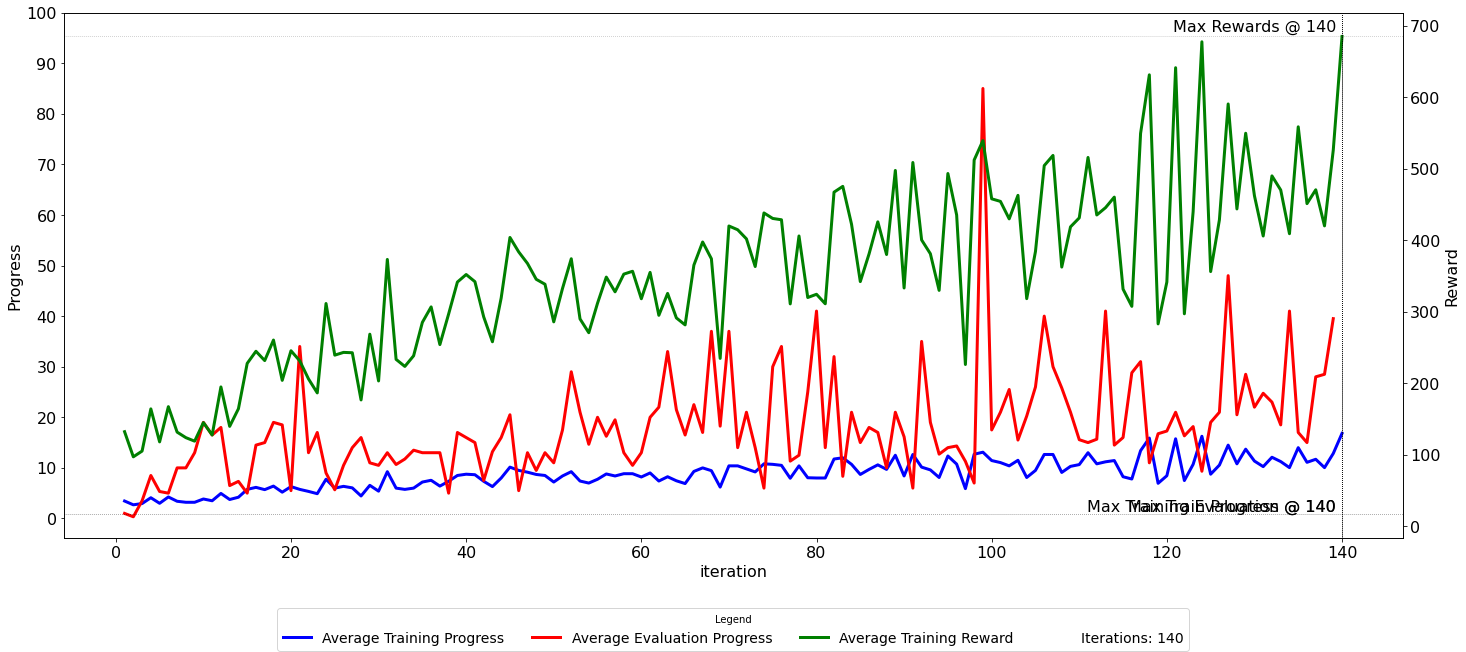

In [13]:
plot_training_graph(sim_df_iterations1, sim_df_iterations_E)

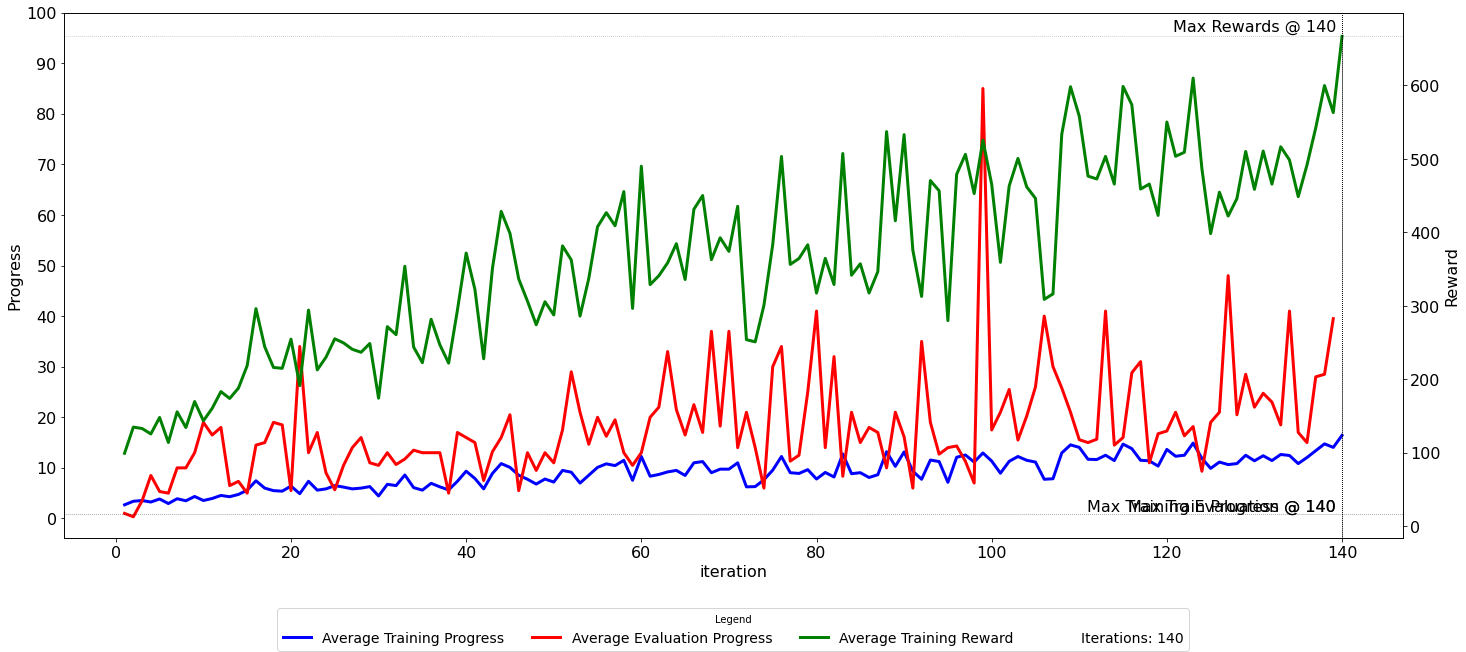

In [14]:
plot_training_graph(sim_df_iterations2, sim_df_iterations_E)

<font size="4">Percent Completed Laps vs. Average Progress for Each Robomaker Container</font>

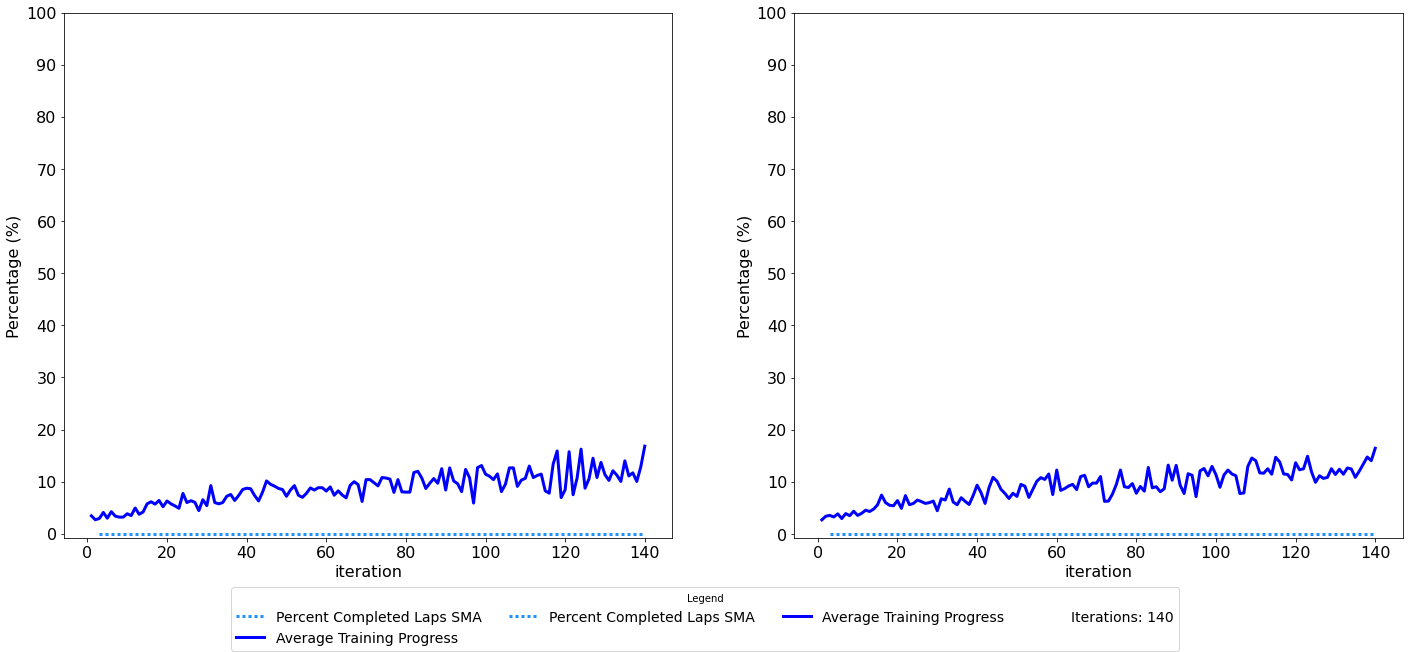

In [15]:
plot_pct_competed_laps(sim_df_iterations1, sim_df_iterations2)

<font size="4">Percent Completed Laps vs. Offtrack vs. Crashed for Each Robomaker Container</font>

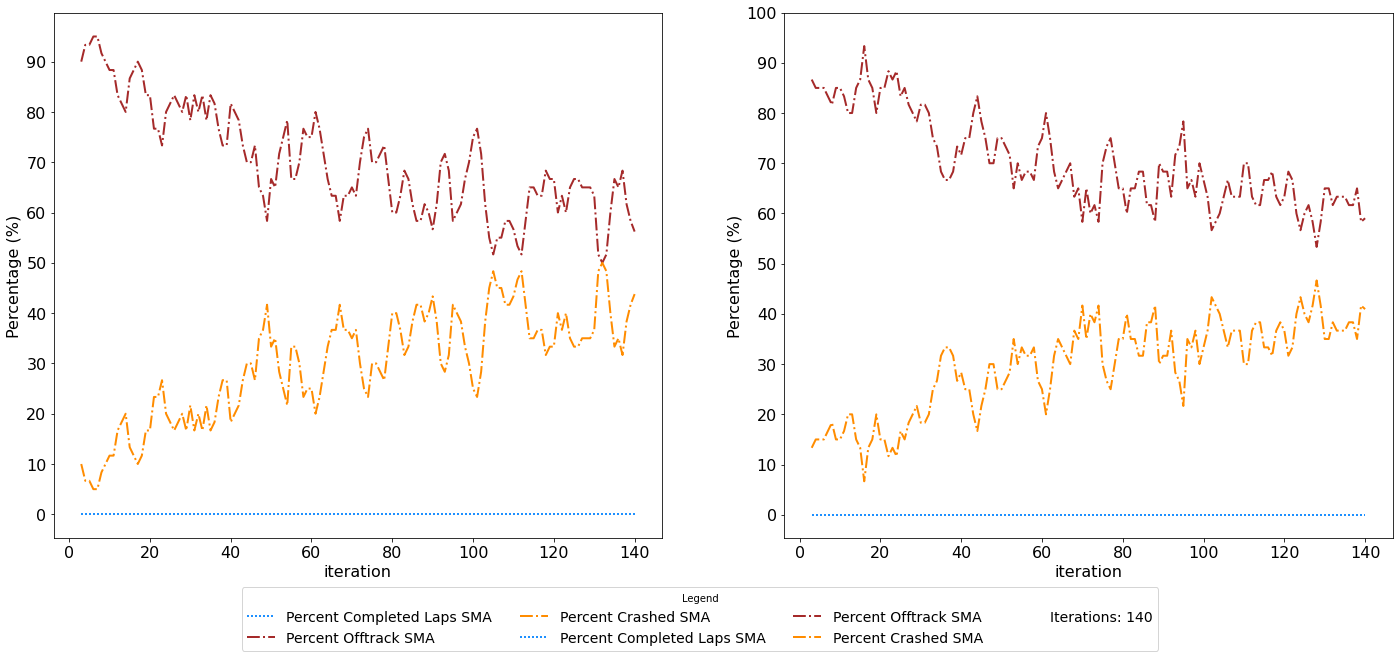

In [16]:
episode_end_status(sim_df_iterations1, sim_df_iterations2)